<div style="
    background: linear-gradient(135deg, #eef2ff, #e0e7ff);
    color: #1e3a8a;
    padding: 28px 32px;
    border-radius: 14px;
    box-shadow: 0 8px 18px rgba(0,0,0,0.10);
">
    <h1 style="margin:0;">📊 Classification Automatique de Produits E-commerce</h1>
    <h3 style="margin-top:8px; font-weight:normal;">
        NOTEBOOK 3 — MODÈLES BASELINE ET AVANCÉS
    </h3>
    <p><b>Projet :</b> Classification Automatique de Produits E-commerce — Flipkart</p>
    <p><b>Objectif :</b> Entraîner et évaluer des modèles de Machine Learning</p>
    <p><b>Baseline :</b> Logistic Regression</p>
    <p><b>Modèles avancés testés :</b></p>
    <ul>
        <li>Random Forest</li>
        <li>XGBoost</li>
        <li>SVM (Support Vector Machine)</li>
        <li>Gradient Boosting</li>
    </ul>
    <p>
        <b>Métriques :</b> Accuracy, Precision, Recall, F1-Score, Confusion Matrix
    </p>
    <p><b>Date :</b> Février 2026</p>
</div>

### IMPORTATION DES BIBLIOTHEQUES

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import time
from collections import defaultdict

# Sklearn - Modèles
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print(" XGBoost non installé. Installation : pip install xgboost")

# Sklearn - Métriques
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Couleurs personnalisées
COLORS = {
    'baseline': '#6C757D',  # Gris pour baseline
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#06A77D',
    'warning': '#F24236',
    'info': '#4ECDC4',
    'purple': '#9B5DE5',
    'yellow': '#F9C74F',
    'teal': '#06FFA5',
    'orange': '#FF6B35',
    'pink': '#FF006E',
    'blue': '#0077B6',
    'green': '#52B788'
}

print(" Bibliothèques importées avec succès !")
print("="*80)

 Bibliothèques importées avec succès !


### CHARGEMENT DES DONNÉES PRÉPROCESSÉES

In [34]:
print("\n" + "="*80)
print(" CHARGEMENT DES DONNÉES PRÉPROCESSÉES")
print("="*80 + "\n")

# Chargement des données
try:
    with open('../outputs/preprocessed_data.pkl', 'rb') as f:
        preprocessed_data = pickle.load(f)
        
    X_train = preprocessed_data['X_train']
    X_val = preprocessed_data['X_val']
    X_test = preprocessed_data['X_test']
    y_train = preprocessed_data['y_train']
    y_val = preprocessed_data['y_val']
    y_test = preprocessed_data['y_test']
    feature_names = preprocessed_data['feature_names']
    target_names = preprocessed_data['target_names']
    tfidf_features = preprocessed_data['tfidf_features']
    
    print(" Données chargées avec succès !")
    print(f"\n Informations sur les datasets :")
    print(f"  • Train      : {X_train.shape}")
    print(f"  • Validation : {X_val.shape}")
    print(f"  • Test       : {X_test.shape}")
    print(f"  • Features   : {tfidf_features}")
    print(f"  • Classes    : {len(target_names)}")
    print(f"\n Noms des classes :")
    for i, name in enumerate(target_names):
        count_train = (y_train == i).sum()
        count_val = (y_val == i).sum()
        count_test = (y_test == i).sum()
        print(f"  {i}: {name:30s} (Train: {count_train:3d}, Val: {count_val:3d}, Test: {count_test:3d})")
    
except FileNotFoundError:
    print(" ERREUR : Fichier 'preprocessed_data.pkl' introuvable !")
    print("Veuillez d'abord exécuter le Notebook 2 pour générer ce fichier.")
    raise
except Exception as e:
    print(f" Erreur lors du chargement : {e}")
    raise

print("\n" + "="*80)


 CHARGEMENT DES DONNÉES PRÉPROCESSÉES

 Données chargées avec succès !

 Informations sur les datasets :
  • Train      : (733, 3100)
  • Validation : (158, 3100)
  • Test       : (158, 3100)
  • Features   : (1049, 3100)
  • Classes    : 7

 Noms des classes :
  0: Baby Care                      (Train: 104, Val:  23, Test:  22)
  1: Beauty and Personal Care       (Train: 105, Val:  23, Test:  22)
  2: Computers                      (Train: 105, Val:  23, Test:  22)
  3: Home Decor & Festive Needs     (Train: 105, Val:  22, Test:  23)
  4: Home Furnishing                (Train: 105, Val:  22, Test:  23)
  5: Kitchen & Dining               (Train: 104, Val:  23, Test:  23)
  6: Watches                        (Train: 105, Val:  22, Test:  23)



### FONCTIONS UTILITAIRES

In [35]:
def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, 
                  model_name, target_names):
    """
    Évalue un modèle de manière complète
    """
    results = {}
    
    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    # Métriques pour chaque ensemble
    for set_name, y_true, y_pred in [
        ('train', y_train, y_pred_train),
        ('val', y_val, y_pred_val),
        ('test', y_test, y_pred_test)
    ]:
        results[set_name] = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
            'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
            'f1_score': f1_score(y_true, y_pred, average='weighted', zero_division=0),
            'confusion_matrix': confusion_matrix(y_true, y_pred),
            'predictions': y_pred
        }
    
    # Classification report (test set)
    results['classification_report'] = classification_report(
        y_test, y_pred_test, target_names=target_names, 
        output_dict=True, zero_division=0
    )
    
    return results

def print_results(results, model_name):
    """Affiche les résultats d'un modèle"""
    print(f"\n{'='*80}")
    print(f" RÉSULTATS : {model_name}")
    print(f"{'='*80}\n")
    
    # Tableau des métriques
    print(f"{'Ensemble':<12} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
    print("-" * 80)
    
    for set_name in ['train', 'val', 'test']:
        r = results[set_name]
        print(f"{set_name.upper():<12} | {r['accuracy']:.4f} ({r['accuracy']*100:5.2f}%) | "
              f"{r['precision']:.4f}    | {r['recall']:.4f}    | {r['f1_score']:.4f}")
    
    # Overfitting
    overfit = (results['train']['accuracy'] - results['val']['accuracy']) * 100
    print(f"\n Overfitting (Train - Val) : {overfit:.2f}%")
    
    if overfit > 10:
        print("   OVERFITTING IMPORTANT !")
    elif overfit > 5:
        print("   Léger overfitting")
    else:
        print("  Pas d'overfitting significatif")

def plot_confusion_matrix(cm, target_names, model_name, save_path=None):
    """Visualise la matrice de confusion"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names,
                linewidths=1, linecolor='black', cbar_kws={'label': 'Proportion'},
                ax=ax, vmin=0, vmax=1)
    
    ax.set_xlabel('Prédictions', fontsize=12, fontweight='bold')
    ax.set_ylabel('Vraies Étiquettes', fontsize=12, fontweight='bold')
    ax.set_title(f' Matrice de confusion - {model_name}', 
                fontsize=14, fontweight='bold', pad=20)
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Dictionnaire pour stocker tous les résultats
all_results = {}

### MODÈLE BASELINE : LOGISTIC REGRESSION

#### Entrainement

In [36]:
print("\n" + "="*80)
print("BASELINE - LOGISTIC REGRESSION")
print("="*80 + "\n")

print(" Ce modèle servira de référence pour tous les autres modèles\n")

# Configuration
print(" Configuration du modèle :")
baseline_params = {
    'max_iter': 1000,
    'C': 1.0,
    'class_weight': 'balanced',
    'solver': 'saga',
    'random_state': 42,
    'n_jobs': -1
}

for param, value in baseline_params.items():
    print(f"  • {param:20s} : {value}")

# Entraînement
print("\n Entraînement de la baseline...")
start_time = time.time()

baseline_model = LogisticRegression(**baseline_params)
baseline_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f" Entraînement terminé en {training_time:.2f}s")


BASELINE - LOGISTIC REGRESSION

 Ce modèle servira de référence pour tous les autres modèles

 Configuration du modèle :
  • max_iter             : 1000
  • C                    : 1.0
  • class_weight         : balanced
  • solver               : saga
  • random_state         : 42
  • n_jobs               : -1

 Entraînement de la baseline...
 Entraînement terminé en 0.37s


### EVALUATION

In [37]:
# Évaluation
print("\n Évaluation sur les 3 ensembles...")
baseline_results = evaluate_model(
    baseline_model, X_train, X_val, X_test,
    y_train, y_val, y_test,
    "Logistic Regression (Baseline)",
    target_names
)
baseline_results['training_time'] = training_time
baseline_results['model'] = baseline_model

# Affichage
print_results(baseline_results, "BASELINE - Logistic Regression")


 Évaluation sur les 3 ensembles...

 RÉSULTATS : BASELINE - Logistic Regression

Ensemble     | Accuracy   | Precision  | Recall     | F1-Score  
--------------------------------------------------------------------------------
TRAIN        | 0.9877 (98.77%) | 0.9882    | 0.9877    | 0.9877
VAL          | 0.9557 (95.57%) | 0.9580    | 0.9557    | 0.9545
TEST         | 0.9494 (94.94%) | 0.9505    | 0.9494    | 0.9481

 Overfitting (Train - Val) : 3.20%
  Pas d'overfitting significatif


#### Matrice de confusion


 Matrice de confusion (Test Set) :



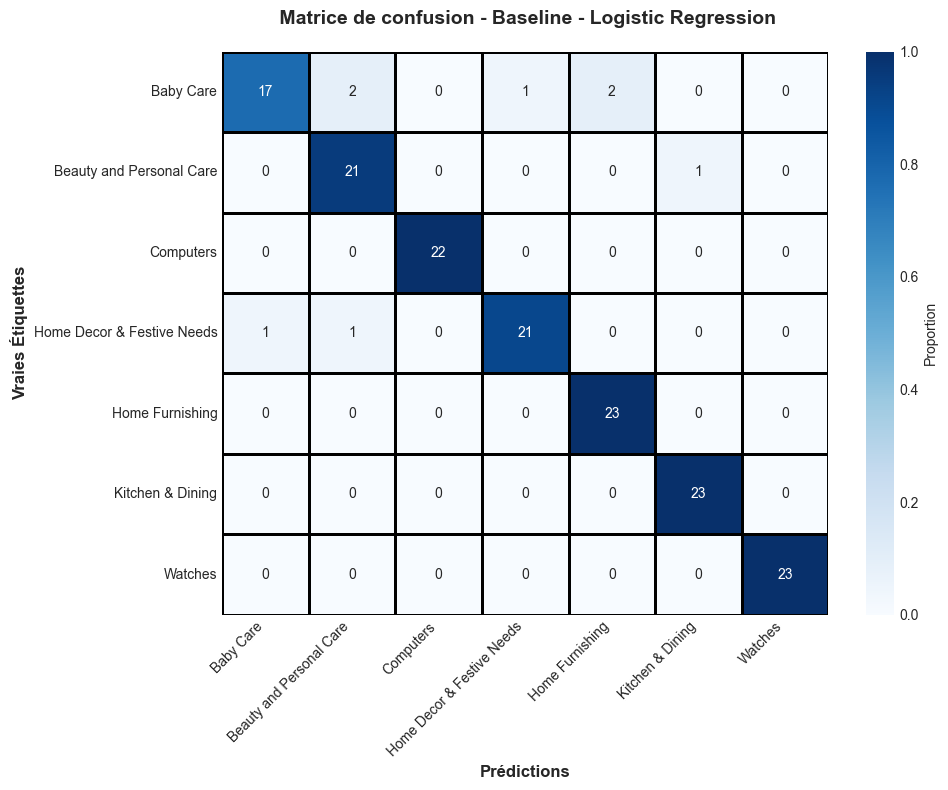


📋 Classification Report (Test Set) :
                            precision    recall  f1-score   support

                 Baby Care       0.94      0.77      0.85        22
  Beauty and Personal Care       0.88      0.95      0.91        22
                 Computers       1.00      1.00      1.00        22
Home Decor & Festive Needs       0.95      0.91      0.93        23
           Home Furnishing       0.92      1.00      0.96        23
          Kitchen & Dining       0.96      1.00      0.98        23
                   Watches       1.00      1.00      1.00        23

                  accuracy                           0.95       158
                 macro avg       0.95      0.95      0.95       158
              weighted avg       0.95      0.95      0.95       158


🎯 BASELINE ÉTABLIE : Test Accuracy = 94.94%


In [38]:
# Matrice de confusion
print("\n Matrice de confusion (Test Set) :\n")
plot_confusion_matrix(
    baseline_results['test']['confusion_matrix'],
    target_names,
    "Baseline - Logistic Regression",
    save_path='../outputs/cm_01_baseline_logistic_regression.png'
)

# Classification Report détaillé
print("\n📋 Classification Report (Test Set) :")
print("="*80)
print(classification_report(y_test, baseline_results['test']['predictions'], 
                           target_names=target_names, zero_division=0))

# Stockage des résultats
all_results['Baseline (Logistic Regression)'] = baseline_results

# Score de référence
baseline_test_acc = baseline_results['test']['accuracy']
baseline_test_f1 = baseline_results['test']['f1_score']
print(f"\n{'='*80}")
print(f"🎯 BASELINE ÉTABLIE : Test Accuracy = {baseline_test_acc*100:.2f}%")


### MODÈLE 1 : RANDOM FOREST

In [39]:
print("\n" + "="*80)
print("🌳 RANDOM FOREST")
print("="*80 + "\n")

print(" Caractéristiques du modèle :")
print("  • Ensemble de multiples arbres de décision")
print("  • Réduit l'overfitting par rapport à un arbre unique")
print("  • Robuste aux outliers")
print("  • Fournit l'importance des features\n")

# Configuration
print(" Configuration :")
rf_params = {
    'n_estimators': 100,
    'max_depth': 20,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'class_weight': 'balanced',
    'random_state': 42,
    'n_jobs': -1
}

for param, value in rf_params.items():
    print(f"  • {param:20s} : {value}")

# Entraînement
print("\n Entraînement du Random Forest...")
start_time = time.time()
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"✅ Entraînement terminé en {training_time:.2f}s ({training_time/60:.2f} min)")



🌳 RANDOM FOREST

 Caractéristiques du modèle :
  • Ensemble de multiples arbres de décision
  • Réduit l'overfitting par rapport à un arbre unique
  • Robuste aux outliers
  • Fournit l'importance des features

 Configuration :
  • n_estimators         : 100
  • max_depth            : 20
  • min_samples_split    : 5
  • min_samples_leaf     : 2
  • class_weight         : balanced
  • random_state         : 42
  • n_jobs               : -1

 Entraînement du Random Forest...
✅ Entraînement terminé en 4.74s (0.08 min)


### EVALUATION

In [40]:
# Évaluation
print("\n Évaluation sur les 3 ensembles...")
rf_results = evaluate_model(
    rf_model, X_train, X_val, X_test,
    y_train, y_val, y_test,
    "Random Forest",
    target_names
)
rf_results['training_time'] = training_time
rf_results['model'] = rf_model

# Affichage
print_results(rf_results, "Random Forest")


 Évaluation sur les 3 ensembles...

 RÉSULTATS : Random Forest

Ensemble     | Accuracy   | Precision  | Recall     | F1-Score  
--------------------------------------------------------------------------------
TRAIN        | 0.9645 (96.45%) | 0.9662    | 0.9645    | 0.9639
VAL          | 0.9304 (93.04%) | 0.9365    | 0.9304    | 0.9294
TEST         | 0.9177 (91.77%) | 0.9232    | 0.9177    | 0.9168

 Overfitting (Train - Val) : 3.41%
  Pas d'overfitting significatif


### MATRICE DE CONFUSION ET RAPPORT DE CLASSIFICATION


 Matrice de confusion (Test Set) :



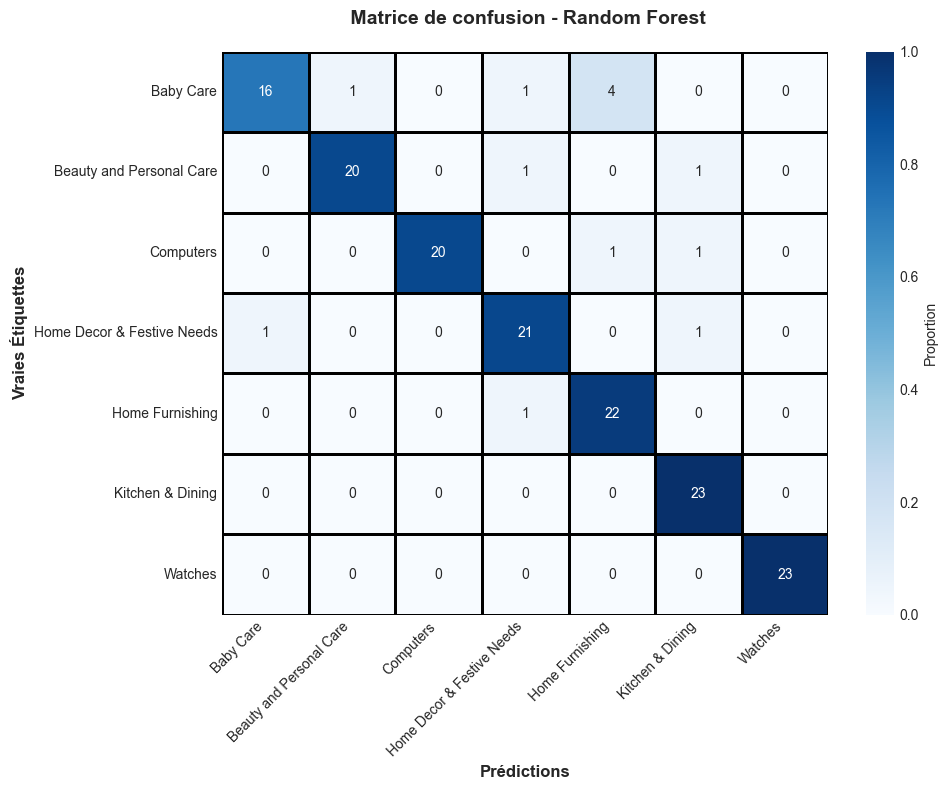


 Classification Report (Test Set) :
                            precision    recall  f1-score   support

                 Baby Care       0.94      0.73      0.82        22
  Beauty and Personal Care       0.95      0.91      0.93        22
                 Computers       1.00      0.91      0.95        22
Home Decor & Festive Needs       0.88      0.91      0.89        23
           Home Furnishing       0.81      0.96      0.88        23
          Kitchen & Dining       0.88      1.00      0.94        23
                   Watches       1.00      1.00      1.00        23

                  accuracy                           0.92       158
                 macro avg       0.92      0.92      0.92       158
              weighted avg       0.92      0.92      0.92       158




In [41]:
# Matrice de confusion
print("\n Matrice de confusion (Test Set) :\n")
plot_confusion_matrix(
    rf_results['test']['confusion_matrix'],
    target_names,
    "Random Forest",
    save_path='../outputs/cm_02_random_forest.png'
)

# Classification Report
print("\n Classification Report (Test Set) :")
print("="*80)
print(classification_report(y_test, rf_results['test']['predictions'], 
                           target_names=target_names, zero_division=0))

# Stocker
all_results['Random Forest'] = rf_results

print("\n" + "="*80)

### MODÈLE 2 : XGBOOST

### ENTRAINEMENT

In [42]:
print("\n" + "="*80)
print(" ÉTAPE 3 : XGBOOST")
print("="*80 + "\n")

print(" Caractéristiques du modèle :")
print("  • Gradient Boosting optimisé et performant")
print("  • Régularisation intégrée")
print("  • Gère automatiquement les valeurs manquantes\n")

# Configuration
print(" Configuration :")
xgb_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'mlogloss'
}

for param, value in xgb_params.items():
    print(f"  • {param:20s} : {value}")

# Entraînement avec poids des classes
print("\n Entraînement de XGBoost (avec sample weights)...")
start_time = time.time()

xgb_model = xgb.XGBClassifier(**xgb_params)

# Calcul des poids pour le déséquilibre
class_counts = np.bincount(y_train)
class_weights = len(y_train) / (len(class_counts) * class_counts)
sample_weights = class_weights[y_train]

xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

training_time = time.time() - start_time
print(f"✅ Entraînement terminé en {training_time:.2f}s ({training_time/60:.2f} min)")


 ÉTAPE 3 : XGBOOST

 Caractéristiques du modèle :
  • Gradient Boosting optimisé et performant
  • Régularisation intégrée
  • Gère automatiquement les valeurs manquantes

 Configuration :
  • n_estimators         : 100
  • max_depth            : 10
  • learning_rate        : 0.1
  • subsample            : 0.8
  • colsample_bytree     : 0.8
  • gamma                : 0
  • random_state         : 42
  • n_jobs               : -1
  • eval_metric          : mlogloss

 Entraînement de XGBoost (avec sample weights)...
✅ Entraînement terminé en 117.71s (1.96 min)


#### Evaluation

In [43]:
# Évaluation
print("\n Évaluation sur les 3 ensembles...")
xgb_results = evaluate_model(
    xgb_model, X_train, X_val, X_test,
    y_train, y_val, y_test,
    "XGBoost",
    target_names
)
xgb_results['training_time'] = training_time
xgb_results['model'] = xgb_model

# Affichage
print_results(xgb_results, "XGBoost")



 Évaluation sur les 3 ensembles...

 RÉSULTATS : XGBoost

Ensemble     | Accuracy   | Precision  | Recall     | F1-Score  
--------------------------------------------------------------------------------
TRAIN        | 0.9986 (99.86%) | 0.9986    | 0.9986    | 0.9986
VAL          | 0.9430 (94.30%) | 0.9459    | 0.9430    | 0.9431
TEST         | 0.9177 (91.77%) | 0.9200    | 0.9177    | 0.9182

 Overfitting (Train - Val) : 5.56%
   Léger overfitting


### Matrice de confusion et rapport de classification


 Matrice de confusion (Test Set) :



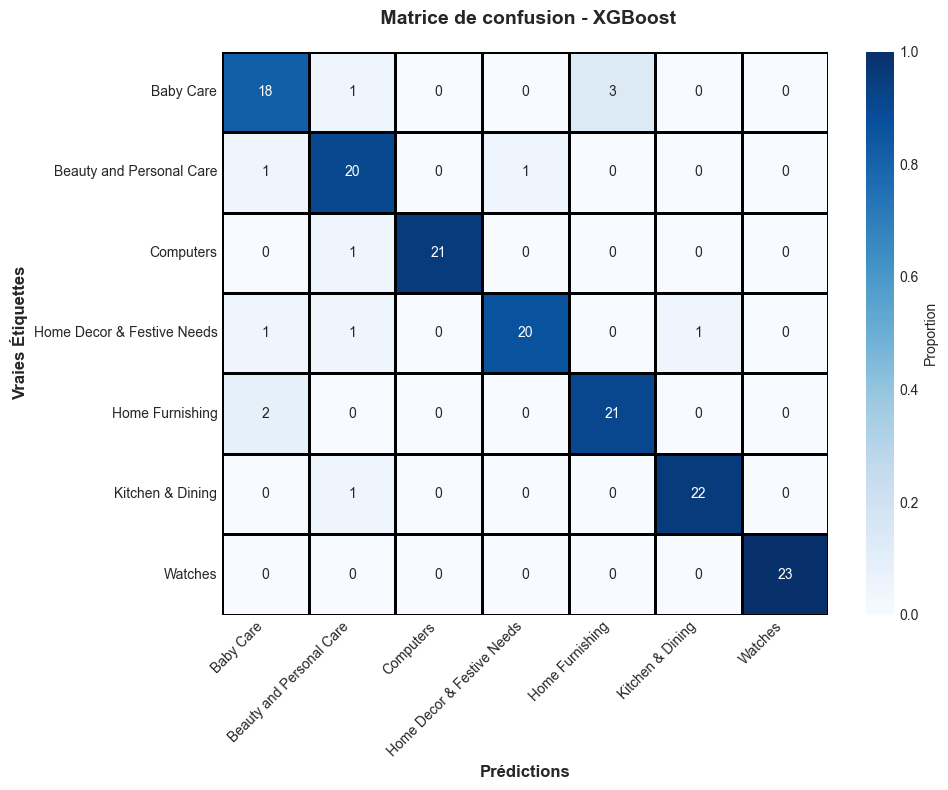


 Classification Report (Test Set) :
                            precision    recall  f1-score   support

                 Baby Care       0.82      0.82      0.82        22
  Beauty and Personal Care       0.83      0.91      0.87        22
                 Computers       1.00      0.95      0.98        22
Home Decor & Festive Needs       0.95      0.87      0.91        23
           Home Furnishing       0.88      0.91      0.89        23
          Kitchen & Dining       0.96      0.96      0.96        23
                   Watches       1.00      1.00      1.00        23

                  accuracy                           0.92       158
                 macro avg       0.92      0.92      0.92       158
              weighted avg       0.92      0.92      0.92       158




In [44]:

# Matrice de confusion
print("\n Matrice de confusion (Test Set) :\n")
plot_confusion_matrix(
    xgb_results['test']['confusion_matrix'],
    target_names,
    "XGBoost",
    save_path='../outputs/cm_03_xgboost.png'
)

# Classification Report
print("\n Classification Report (Test Set) :")
print("="*80)
print(classification_report(y_test, xgb_results['test']['predictions'], 
                            target_names=target_names, zero_division=0))

# Stocker
all_results['XGBoost'] = xgb_results

print("\n" + "="*80)

### MODÈLE 3 : SVM (LINEAR)

In [45]:
print("\n" + "="*80)
print(" ÉTAPE 4 : SVM (SUPPORT VECTOR MACHINE)")
print("="*80 + "\n")

print(" Caractéristiques du modèle :")
print("  • Trouve l'hyperplan optimal séparant les classes")
print("  • Noyau linéaire (rapide pour haute dimension)")
print("  • Efficace avec des données textuelles")
print("  • Bonne généralisation\n")

# Configuration
print(" Configuration :")
svm_params = {
    'C': 1.0,
    'class_weight': 'balanced',
    'max_iter': 1000,
    'random_state': 42
}

for param, value in svm_params.items():
    print(f"  • {param:20s} : {value}")

# Entraînement
print("\n⏳ Entraînement du SVM...")
start_time = time.time()

svm_model = LinearSVC(**svm_params)
svm_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"✅ Entraînement terminé en {training_time:.2f}s")


 ÉTAPE 4 : SVM (SUPPORT VECTOR MACHINE)

 Caractéristiques du modèle :
  • Trouve l'hyperplan optimal séparant les classes
  • Noyau linéaire (rapide pour haute dimension)
  • Efficace avec des données textuelles
  • Bonne généralisation

 Configuration :
  • C                    : 1.0
  • class_weight         : balanced
  • max_iter             : 1000
  • random_state         : 42

⏳ Entraînement du SVM...
✅ Entraînement terminé en 0.08s


### Evaluation

In [46]:
# Évaluation
print("\n Évaluation sur les 3 ensembles...")
svm_results = evaluate_model(
    svm_model, X_train, X_val, X_test,
    y_train, y_val, y_test,
    "SVM (Linear)",
    target_names
)
svm_results['training_time'] = training_time
svm_results['model'] = svm_model

# Affichage
print_results(svm_results, "SVM (Linear)")


 Évaluation sur les 3 ensembles...

 RÉSULTATS : SVM (Linear)

Ensemble     | Accuracy   | Precision  | Recall     | F1-Score  
--------------------------------------------------------------------------------
TRAIN        | 0.9986 (99.86%) | 0.9986    | 0.9986    | 0.9986
VAL          | 0.9620 (96.20%) | 0.9656    | 0.9620    | 0.9610
TEST         | 0.9557 (95.57%) | 0.9562    | 0.9557    | 0.9549

 Overfitting (Train - Val) : 3.66%
  Pas d'overfitting significatif


#### Matrice de confusion et rapport de classification


 Matrice de confusion (Test Set) :



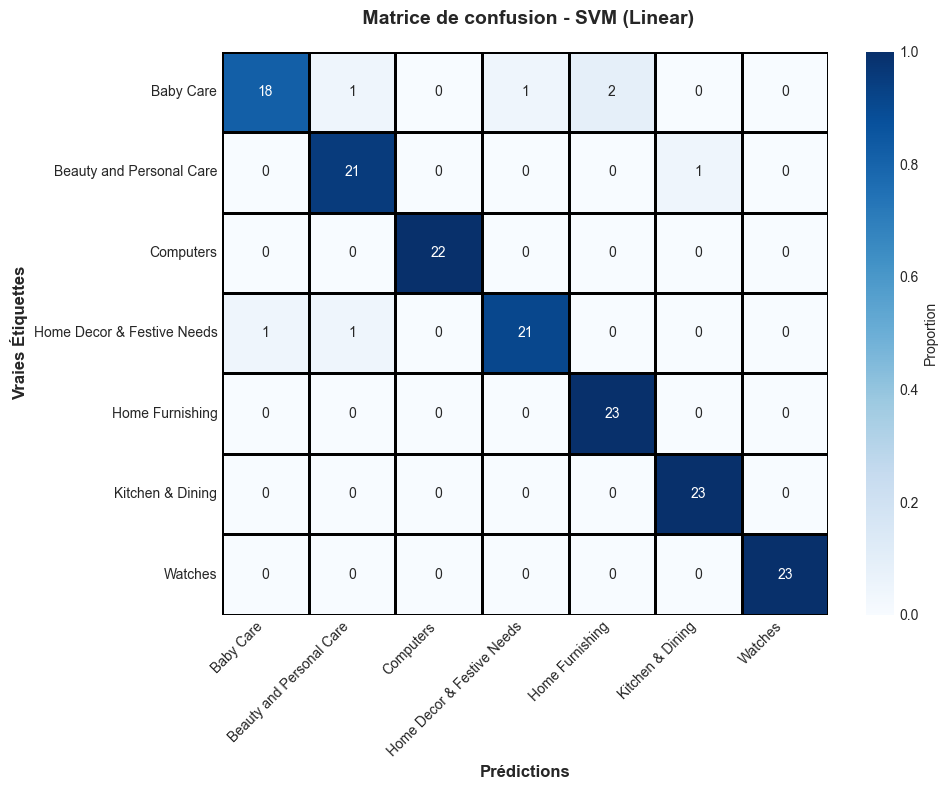


📋 Classification Report (Test Set) :
                            precision    recall  f1-score   support

                 Baby Care       0.95      0.82      0.88        22
  Beauty and Personal Care       0.91      0.95      0.93        22
                 Computers       1.00      1.00      1.00        22
Home Decor & Festive Needs       0.95      0.91      0.93        23
           Home Furnishing       0.92      1.00      0.96        23
          Kitchen & Dining       0.96      1.00      0.98        23
                   Watches       1.00      1.00      1.00        23

                  accuracy                           0.96       158
                 macro avg       0.96      0.96      0.95       158
              weighted avg       0.96      0.96      0.95       158




In [47]:
# Matrice de confusion
print("\n Matrice de confusion (Test Set) :\n")
plot_confusion_matrix(
    svm_results['test']['confusion_matrix'],
    target_names,
    "SVM (Linear)",
    save_path='../outputs/cm_04_svm_linear.png'
)

# Classification Report
print("\n📋 Classification Report (Test Set) :")
print("="*80)
print(classification_report(y_test, svm_results['test']['predictions'], 
                           target_names=target_names, zero_division=0))

# Stocker
all_results['SVM'] = svm_results

print("\n" + "="*80)

### MODÈLE 4 : GRADIENT BOOSTING

In [48]:
print("\n" + "="*80)
print(" ÉTAPE 5 : GRADIENT BOOSTING")
print("="*80 + "\n")

print(" Caractéristiques du modèle :")
print("  • Boosting séquentiel d'arbres faibles")
print("  • Corrige les erreurs des itérations précédentes")
print("  • Peut être très performant")
print("  • Plus lent que Random Forest mais souvent meilleur\n")

# Configuration
print(" Configuration :")
gb_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'random_state': 42
}

for param, value in gb_params.items():
    print(f"  • {param:20s} : {value}")

# Entraînement
print("\n Entraînement du Gradient Boosting...")
print("   (Cela peut prendre BEAUCOUP de temps...)")
start_time = time.time()

gb_model = GradientBoostingClassifier(**gb_params)
gb_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f" Entraînement terminé en {training_time:.2f}s ({training_time/60:.2f} min)")


 ÉTAPE 5 : GRADIENT BOOSTING

 Caractéristiques du modèle :
  • Boosting séquentiel d'arbres faibles
  • Corrige les erreurs des itérations précédentes
  • Peut être très performant
  • Plus lent que Random Forest mais souvent meilleur

 Configuration :
  • n_estimators         : 100
  • max_depth            : 10
  • learning_rate        : 0.1
  • subsample            : 0.8
  • random_state         : 42

 Entraînement du Gradient Boosting...
   (Cela peut prendre BEAUCOUP de temps...)
 Entraînement terminé en 117.01s (1.95 min)


#### EVALUATION DU MODELE

In [49]:
# Évaluation
print("\n Évaluation sur les 3 ensembles...")
gb_results = evaluate_model(
    gb_model, X_train, X_val, X_test,
    y_train, y_val, y_test,
    "Gradient Boosting",
    target_names
)
gb_results['training_time'] = training_time
gb_results['model'] = gb_model

# Affichage
print_results(gb_results, "Gradient Boosting")


 Évaluation sur les 3 ensembles...

 RÉSULTATS : Gradient Boosting

Ensemble     | Accuracy   | Precision  | Recall     | F1-Score  
--------------------------------------------------------------------------------
TRAIN        | 0.9986 (99.86%) | 0.9986    | 0.9986    | 0.9986
VAL          | 0.9304 (93.04%) | 0.9424    | 0.9304    | 0.9333
TEST         | 0.9241 (92.41%) | 0.9262    | 0.9241    | 0.9246

 Overfitting (Train - Val) : 6.83%
   Léger overfitting


#### MATRICE DE CONFUSION ET RAPPORT DE CLASSIFICATION


 Matrice de confusion (Test Set) :



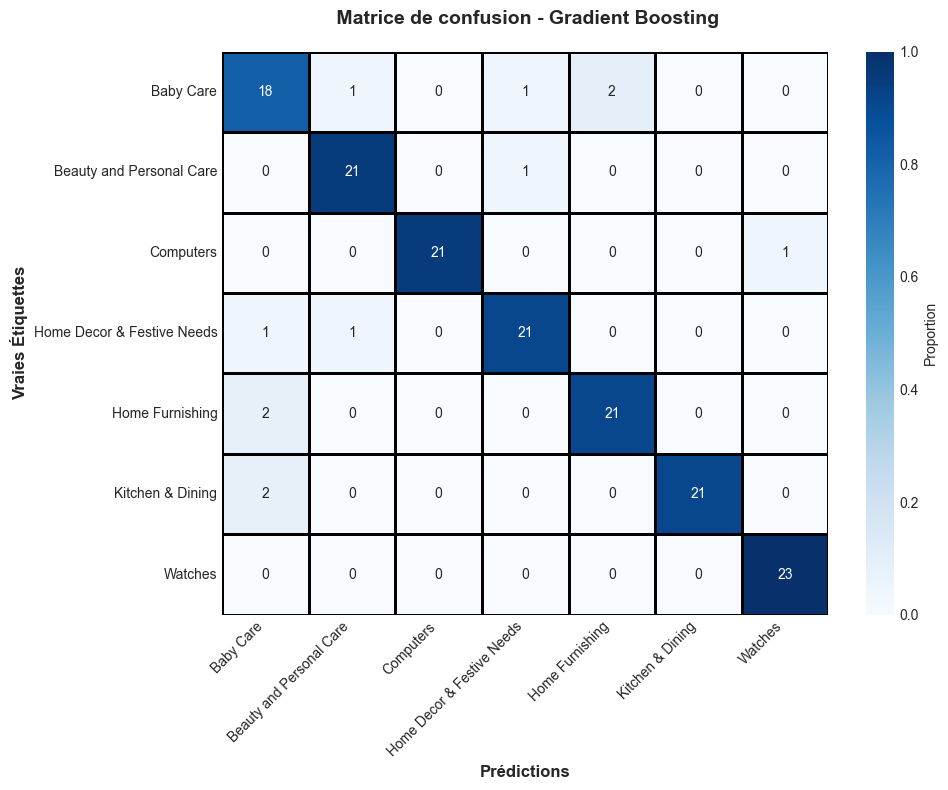


 Classification Report (Test Set) :
                            precision    recall  f1-score   support

                 Baby Care       0.78      0.82      0.80        22
  Beauty and Personal Care       0.91      0.95      0.93        22
                 Computers       1.00      0.95      0.98        22
Home Decor & Festive Needs       0.91      0.91      0.91        23
           Home Furnishing       0.91      0.91      0.91        23
          Kitchen & Dining       1.00      0.91      0.95        23
                   Watches       0.96      1.00      0.98        23

                  accuracy                           0.92       158
                 macro avg       0.93      0.92      0.92       158
              weighted avg       0.93      0.92      0.92       158


 TOUS LES MODÈLES INDIVIDUELS ENTRAÎNÉS !


In [50]:
# Matrice de confusion
print("\n Matrice de confusion (Test Set) :\n")
plot_confusion_matrix(
    gb_results['test']['confusion_matrix'],
    target_names,
    "Gradient Boosting",
    save_path='../outputs/cm_05_gradient_boosting.png'
)

# Classification Report
print("\n Classification Report (Test Set) :")
print("="*80)
print(classification_report(y_test, gb_results['test']['predictions'], 
                           target_names=target_names, zero_division=0))

# Stockage
all_results['Gradient Boosting'] = gb_results

print("\n" + "="*80)
print(" TOUS LES MODÈLES INDIVIDUELS ENTRAÎNÉS !")
print("="*80)

#### Résumé de tous les modèles

In [51]:
print(f"\n RÉSUMÉ DES PERFORMANCES (Test Accuracy) :\n")
print(f"{'Modèle':<35s} | {'Test Acc':<12s} | {'vs Baseline':<15s}")
print("-" * 70)

for model_name, results in all_results.items():
    test_f1 = results['test']['f1_score']
    diff = (test_f1 - baseline_test_f1) * 100
    marker = " BASELINE" if "Baseline" in model_name else ""
    print(f"{model_name:<35s} | {test_f1*100:6.2f}%      | {diff:+6.2f} pts     {marker}")


 RÉSUMÉ DES PERFORMANCES (Test Accuracy) :

Modèle                              | Test Acc     | vs Baseline    
----------------------------------------------------------------------
Baseline (Logistic Regression)      |  94.81%      |  +0.00 pts      BASELINE
Random Forest                       |  91.68%      |  -3.13 pts     
XGBoost                             |  91.82%      |  -2.99 pts     
SVM                                 |  95.49%      |  +0.67 pts     
Gradient Boosting                   |  92.46%      |  -2.35 pts     


### TABLEAU COMPARATIF COMPLET

In [52]:
print("\n" + "="*80)
print(" ÉTAPE 6 : COMPARAISON GLOBALE DE TOUS LES MODÈLES")
print("="*80 + "\n")

# le DataFrame comparatif
comparison_data = []

for model_name, results in all_results.items():
    comparison_data.append({
        'Modèle': model_name,
        'Train Acc (%)': results['train']['accuracy'] * 100,
        'Val Acc (%)': results['val']['accuracy'] * 100,
        'Test Acc (%)': results['test']['accuracy'] * 100,
        'Test F1': results['test']['f1_score'],
        'Test Precision': results['test']['precision'],
        'Test Recall': results['test']['recall'],
        'Temps (s)': results['training_time'],
        'Overfitting (%)': (results['train']['accuracy'] - 
                           results['val']['accuracy']) * 100,
        'vs Baseline (pts)': (results['test']['accuracy'] - baseline_test_acc) * 100
    })

comparison_df = pd.DataFrame(comparison_data)


comparison_df_sorted = comparison_df.sort_values('Test F1', ascending=False)

print("📋 TABLEAU COMPARATIF COMPLET :")
print("="*80)
print(comparison_df_sorted.to_string(index=False))

print("\n" + "="*80)


 ÉTAPE 6 : COMPARAISON GLOBALE DE TOUS LES MODÈLES

📋 TABLEAU COMPARATIF COMPLET :
                        Modèle  Train Acc (%)  Val Acc (%)  Test Acc (%)  Test F1  Test Precision  Test Recall  Temps (s)  Overfitting (%)  vs Baseline (pts)
                           SVM      99.863574    96.202532     95.569620 0.954869        0.956236     0.955696   0.079787         3.661043           0.632911
Baseline (Logistic Regression)      98.772169    95.569620     94.936709 0.948139        0.950532     0.949367   0.370982         3.202549           0.000000
             Gradient Boosting      99.863574    93.037975     92.405063 0.924601        0.926241     0.924051 117.013308         6.825600          -2.531646
                       XGBoost      99.863574    94.303797     91.772152 0.918235        0.920020     0.917722 117.705347         5.559777          -3.164557
                 Random Forest      96.452933    93.037975     91.772152 0.916796        0.923229     0.917722   4.741213     

### VISUALISATIONS COMPARATIVES

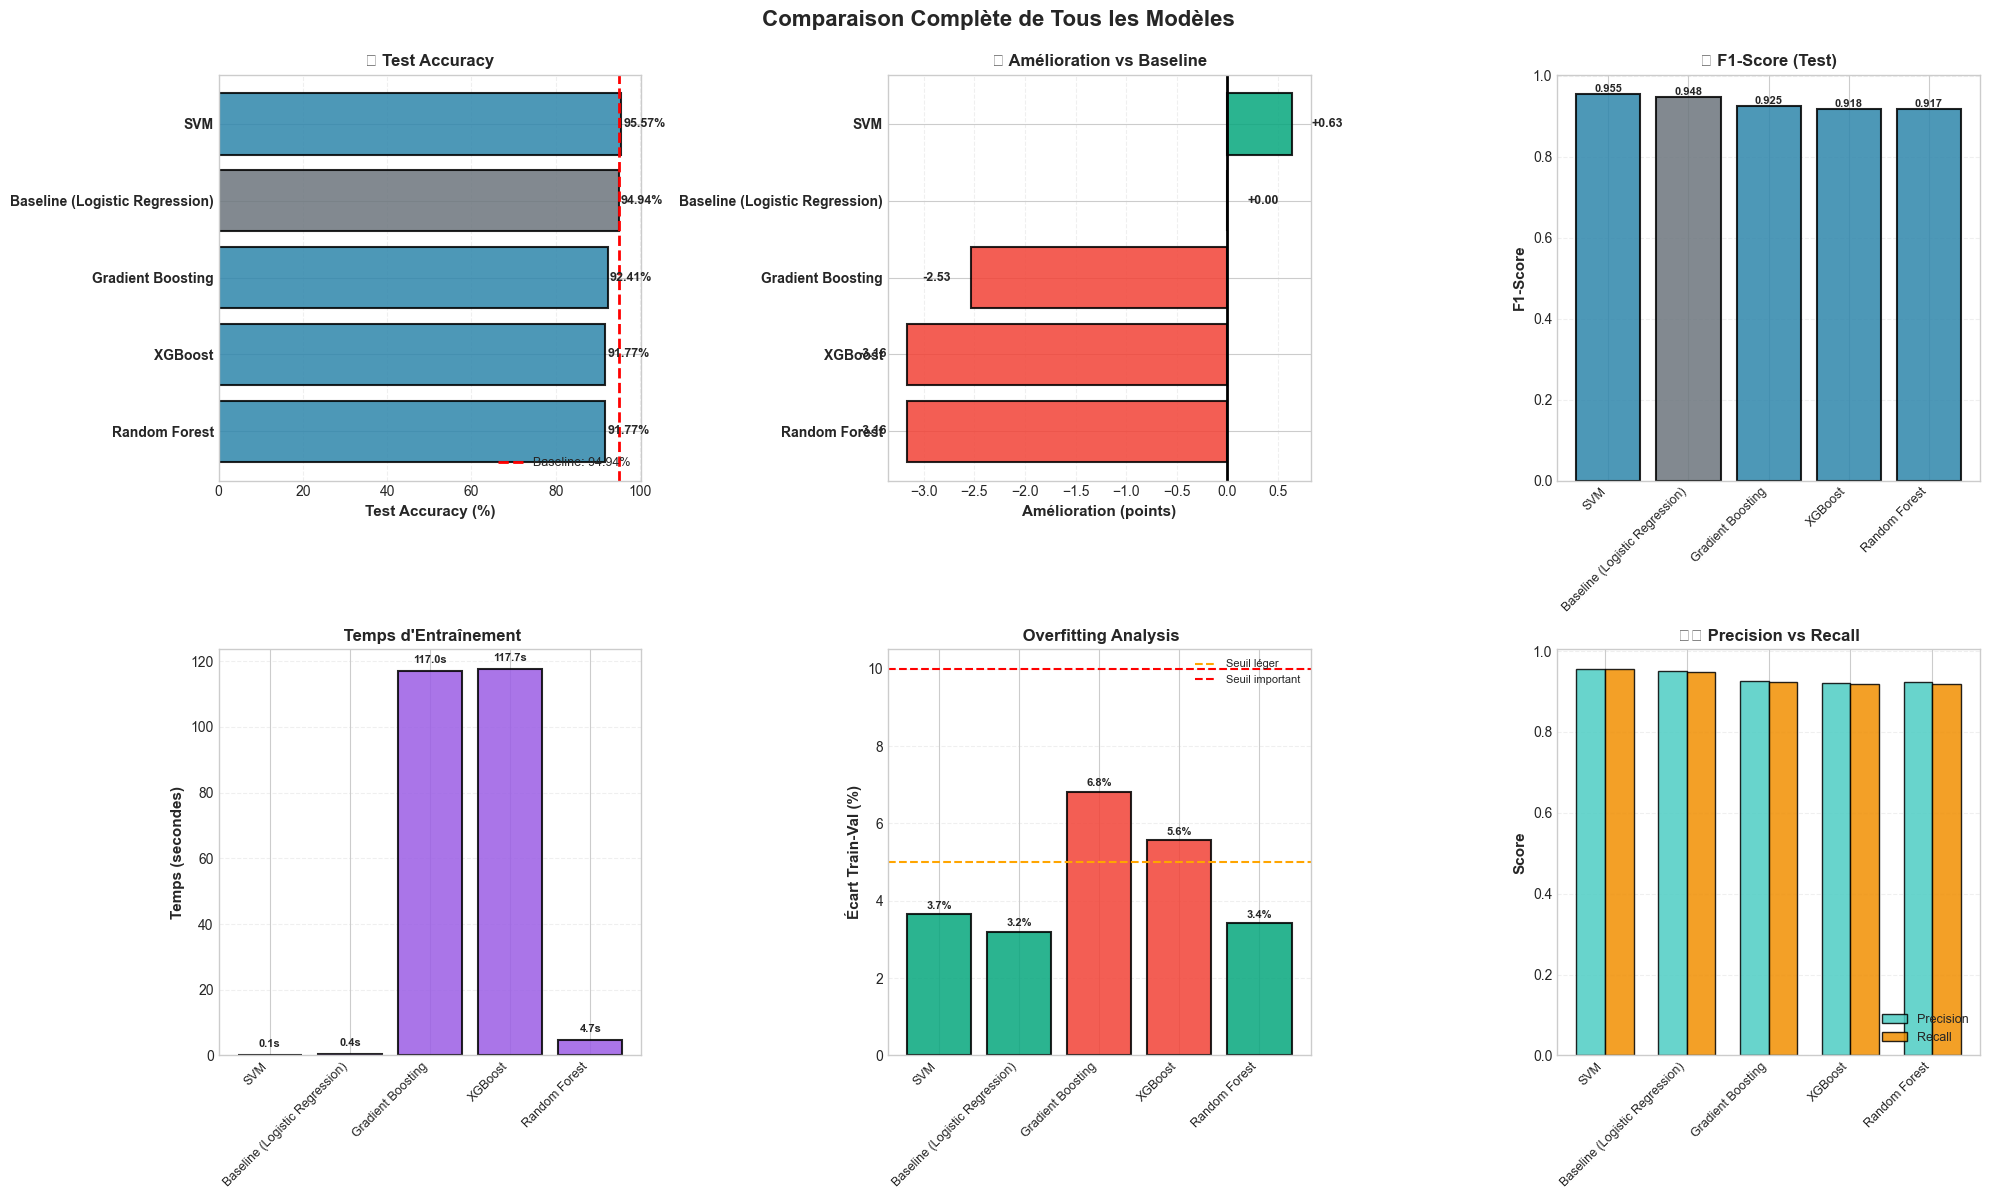

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

models_list = comparison_df_sorted['Modèle'].tolist()
colors_list = [COLORS['baseline'] if 'Baseline' in m else COLORS['primary'] 
               for m in models_list]

# 1. Test Accuracy
ax = axes[0]
bars = ax.barh(range(len(models_list)), comparison_df_sorted['Test Acc (%)'], 
               color=colors_list, edgecolor='black', linewidth=1.5, alpha=0.85)
ax.set_yticks(range(len(models_list)))
ax.set_yticklabels(models_list, fontsize=10, fontweight='bold')
ax.set_xlabel('Test Accuracy (%)', fontsize=11, fontweight='bold')
ax.set_title('📊 Test Accuracy', fontsize=12, fontweight='bold')
ax.axvline(baseline_test_acc*100, color='red', linestyle='--', linewidth=2, 
          label=f'Baseline: {baseline_test_acc*100:.2f}%')
ax.legend(loc='lower right', fontsize=9)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.invert_yaxis()

for i, val in enumerate(comparison_df_sorted['Test Acc (%)']):
    ax.text(val + 0.5, i, f'{val:.2f}%', va='center', fontweight='bold', fontsize=9)

# 2. Amélioration vs Baseline
ax = axes[1]
improvements = comparison_df_sorted['vs Baseline (pts)'].tolist()
colors_improvement = [COLORS['success'] if x > 0 else COLORS['baseline'] 
                     if x == 0 else COLORS['warning'] for x in improvements]
bars = ax.barh(range(len(models_list)), improvements, 
               color=colors_improvement, edgecolor='black', linewidth=1.5, alpha=0.85)
ax.set_yticks(range(len(models_list)))
ax.set_yticklabels(models_list, fontsize=10, fontweight='bold')
ax.set_xlabel('Amélioration (points)', fontsize=11, fontweight='bold')
ax.set_title('📈 Amélioration vs Baseline', fontsize=12, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=2)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.invert_yaxis()

for i, val in enumerate(improvements):
    ax.text(val + (0.2 if val >= 0 else -0.2), i, f'{val:+.2f}', 
           va='center', fontweight='bold', fontsize=9,
           ha='left' if val >= 0 else 'right')

# 3. F1-Score
ax = axes[2]
bars = ax.bar(range(len(models_list)), comparison_df_sorted['Test F1'], 
              color=colors_list, edgecolor='black', linewidth=1.5, alpha=0.85)
ax.set_xticks(range(len(models_list)))
ax.set_xticklabels(models_list, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax.set_title('📊 F1-Score (Test)', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')

for i, (bar, val) in enumerate(zip(bars, comparison_df_sorted['Test F1'])):
    ax.text(i, val + 0.005, f'{val:.3f}', ha='center', fontweight='bold', fontsize=8)

# 4. Temps d'entraînement
ax = axes[3]
times = comparison_df_sorted['Temps (s)'].tolist()
bars = ax.bar(range(len(models_list)), times, 
              color=COLORS['purple'], edgecolor='black', linewidth=1.5, alpha=0.85)
ax.set_xticks(range(len(models_list)))
ax.set_xticklabels(models_list, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Temps (secondes)', fontsize=11, fontweight='bold')
ax.set_title(' Temps d\'Entraînement', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')

for i, (bar, val) in enumerate(zip(bars, times)):
    ax.text(i, val + max(times)*0.02, f'{val:.1f}s', 
           ha='center', fontweight='bold', fontsize=8)

# 5. Overfitting
ax = axes[4]
overfit_vals = comparison_df_sorted['Overfitting (%)'].tolist()
colors_overfit = [COLORS['success'] if x < 5 else COLORS['warning'] 
                 if x < 10 else COLORS['warning'] for x in overfit_vals]
bars = ax.bar(range(len(models_list)), overfit_vals, 
              color=colors_overfit, edgecolor='black', linewidth=1.5, alpha=0.85)
ax.set_xticks(range(len(models_list)))
ax.set_xticklabels(models_list, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Écart Train-Val (%)', fontsize=11, fontweight='bold')
ax.set_title(' Overfitting Analysis', fontsize=12, fontweight='bold')
ax.axhline(5, color='orange', linestyle='--', linewidth=1.5, label='Seuil léger')
ax.axhline(10, color='red', linestyle='--', linewidth=1.5, label='Seuil important')
ax.legend(loc='best', fontsize=8)
ax.grid(axis='y', alpha=0.3, linestyle='--')

for i, (bar, val) in enumerate(zip(bars, overfit_vals)):
    ax.text(i, val + max(overfit_vals)*0.02, f'{val:.1f}%', 
           ha='center', fontweight='bold', fontsize=8)

# 6. Précision vs Recall
ax = axes[5]
precisions = comparison_df_sorted['Test Precision'].tolist()
recalls = comparison_df_sorted['Test Recall'].tolist()
x = np.arange(len(models_list))
width = 0.35

bars1 = ax.bar(x - width/2, precisions, width, label='Precision', 
               color=COLORS['info'], edgecolor='black', alpha=0.85)
bars2 = ax.bar(x + width/2, recalls, width, label='Recall', 
               color=COLORS['accent'], edgecolor='black', alpha=0.85)

ax.set_xticks(x)
ax.set_xticklabels(models_list, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.set_title('⚖️ Precision vs Recall', fontsize=12, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.suptitle(' Comparaison Complète de Tous les Modèles', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../outputs/global_comparison_all_models.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("="*80)

### SÉLECTION DU MEILLEUR MODÈLE

In [ ]:
print("\n" + "="*80)
print(" SÉLECTION DU MEILLEUR MODÈLE")
print("="*80 + "\n")

print("CRITÈRE DE SÉLECTION : F1-Score (métrique équilibrée)\n")

# Identification du meilleur modèle
best_idx = comparison_df_sorted.index[0]
best_model_name = comparison_df_sorted.loc[best_idx, 'Modèle']
best_test_acc = comparison_df_sorted.loc[best_idx, 'Test Acc (%)']
best_improvement = comparison_df_sorted.loc[best_idx, 'vs Baseline (pts)']
best_f1 = comparison_df_sorted.loc[best_idx, 'Test F1']

print(f"{'='*80}")
print(f" MEILLEUR MODÈLE : {best_model_name}")
print(f"{'='*80}\n")

print(f" Performances :")
print(f"  • Test F1-Score  : {best_f1:.4f}  CRITÈRE PRINCIPAL")
print(f"  • Test Accuracy  : {best_test_acc:.2f}%")
print(f"  • vs Baseline    : {best_improvement:+.2f} points")
print(f"  • Overfitting    : {comparison_df_sorted.loc[best_idx, 'Overfitting (%)']:.2f}%")
print(f"  • Temps training : {comparison_df_sorted.loc[best_idx, 'Temps (s)']:.1f}s")

if best_improvement > 0:
    print(f"\n✅ Le modèle {best_model_name} AMÉLIORE la baseline de {best_improvement:.2f} points ! 🎉")
elif best_improvement == 0:
    print(f"\n⚖️  Le modèle {best_model_name} ÉGALE la baseline")
else:
    print(f"\n⚠️  ATTENTION : Aucun modèle n'a battu la baseline !")
    print(f"   La Logistic Regression reste la meilleure option.")

print("\n" + "="*80)

# Classement final
print("\n📈 CLASSEMENT FINAL (par Test F1-Score) :")
print("="*80 + "\n")

for i, (idx, row) in enumerate(comparison_df_sorted.iterrows(), 1):
    medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"{i}."
    marker = "📍 BASELINE" if 'Baseline' in row['Modèle'] else ""
    print(f"{medal} {row['Modèle']:30s} : F1={row['Test F1']:.4f} "
          f"(Acc: {row['Test Acc (%)']:5.2f}%) {marker}")

print("\n" + "="*80)

# Sauvegarde du modèle avant optimisation
print("\n💾 Sauvegarde du meilleur modèle (avant optimisation) :")
best_model_before_opt = all_results[best_model_name]['model']

with open('../outputs/best_model_before_optimization.pkl', 'wb') as f:
    pickle.dump(best_model_before_opt, f)

print(f"✅ Modèle sauvegardé : {best_model_name}")

# Sauvegarde du le tableau comparatif
comparison_df_sorted.to_csv('../outputs/models_comparison.csv', index=False)
print(f"✅ Tableau comparatif sauvegardé : models_comparison.csv")

print("\n" + "="*80)
print("📊 NOTEBOOK 3 - PARTIE 4/5 TERMINÉE")
print("="*80)
print(f"\n🏆 Meilleur modèle sélectionné : {best_model_name}")
print(f"   Test Accuracy : {best_test_acc:.2f}%")
print("\n⏳ Prochaine étape : Optimisation par GridSearchCV")
print("="*80)


 SÉLECTION DU MEILLEUR MODÈLE

CRITÈRE DE SÉLECTION : F1-Score (métrique équilibrée)

 MEILLEUR MODÈLE : SVM

 Performances :
  • Test F1-Score  : 0.9549  CRITÈRE PRINCIPAL
  • Test Accuracy  : 95.57%
  • vs Baseline    : +0.63 points
  • Overfitting    : 3.66%
  • Temps training : 0.1s

✅ Le modèle SVM AMÉLIORE la baseline de 0.63 points ! 🎉


📈 CLASSEMENT FINAL (par Test F1-Score) :

🥇 SVM                            : F1=0.9549 (Acc: 95.57%) 
🥈 Baseline (Logistic Regression) : F1=0.9481 (Acc: 94.94%) 📍 BASELINE
🥉 Gradient Boosting              : F1=0.9246 (Acc: 92.41%) 
4. XGBoost                        : F1=0.9182 (Acc: 91.77%) 
5. Random Forest                  : F1=0.9168 (Acc: 91.77%) 


💾 Sauvegarde du meilleur modèle (avant optimisation) :
✅ Modèle sauvegardé : SVM
✅ Tableau comparatif sauvegardé : models_comparison.csv

📊 NOTEBOOK 3 - PARTIE 4/5 TERMINÉE

🏆 Meilleur modèle sélectionné : SVM
   Test Accuracy : 95.57%

⏳ Prochaine étape : Optimisation par GridSearchCV


### OPTIMISATION PAR GRIDSEARCHCV

In [55]:
## import de GridSearchCV et autres utilitaires nécessaires pour l'optimisation
from sklearn.model_selection import GridSearchCV

from scipy.stats import loguniform


In [56]:
print("\n" + "="*80)
print(" ÉTAPE 8 : OPTIMISATION DU MEILLEUR MODÈLE PAR GRIDSEARCHCV")
print("="*80 + "\n")

print(f" Modèle à optimiser : {best_model_name}")
print(f"   Performance actuelle (Test F1) : {best_f1:.4f}\n")

# Définition des grilles de paramètres selon le modèle
print("Définition de la grille de paramètres...\n")

if best_model_name == 'Random Forest':
    print("Grille pour Random Forest :")
    param_grid = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'class_weight': ['balanced']
    }
    base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    
elif best_model_name == 'XGBoost':
    print("Grille pour XGBoost :")
    param_grid = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2]
    }
    base_model = xgb.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss')
    
elif best_model_name == 'SVM':
    print("Grille pour SVM (LinearSVC) :")
    param_grid = {
        'C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 50.0, 100.0],
        'class_weight': ['balanced', None],
        'max_iter': [1000, 1500, 2000, 3000],
        'loss': ['hinge', 'squared_hinge']
    }
    base_model = LinearSVC(random_state=42)
    
elif best_model_name == 'Gradient Boosting':
    print("Grille pour Gradient Boosting :")
    param_grid = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = GradientBoostingClassifier(random_state=42)
    
elif 'Logistic Regression' in best_model_name:
    print("Grille pour Logistic Regression :")
    param_grid = {
        'C': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 50.0, 100.0],
        'solver': ['saga', 'lbfgs', 'liblinear'],
        'max_iter': [1000, 2000, 3000],
        'class_weight': ['balanced', None],
        'penalty': ['l2']
    }
    base_model = LogisticRegression(random_state=42, n_jobs=-1)
    
else:
    print(f" Pas de grille définie pour {best_model_name}")
    param_grid = {}
    base_model = all_results[best_model_name]['model']

print("\nParamètres à optimiser :")
for param, values in param_grid.items():
    print(f"  • {param:20s} : {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\n Nombre total de combinaisons à tester : {total_combinations}")

# Avertissement si beaucoup de combinaisons
if total_combinations > 500:
    print(f"  ATTENTION : {total_combinations} combinaisons = temps d'exécution très long !")
    print(f"   Estimation : {total_combinations * 3 / 60:.1f} à {total_combinations * 10 / 60:.1f} minutes")

# GridSearchCV
print(f"\n Lancement de GridSearchCV...")
print(f"   Stratégie de validation : 3-fold Cross-Validation")
print(f"   Métrique d'optimisation : F1-Score (weighted) 🎯")
print(f"   Parallélisation         : Activée (tous les cœurs)\n")

start_time = time.time()

try:
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=3,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=2,
        error_score='raise',
        return_train_score=True
    )
    
    # Entraînement sur le train set
    grid_search.fit(X_train, y_train)
    optimized_model = grid_search.best_estimator_
    optimization_time = time.time() - start_time
    
    print(f"\n✅ Optimisation terminée avec succès !")
    print(f"   Temps total : {optimization_time:.2f}s ({optimization_time/60:.2f} min)")
    
    # Meilleurs paramètres
    print(f"\n{'='*80}")
    print(f" MEILLEURS PARAMÈTRES TROUVÉS PAR GRIDSEARCHCV")
    print(f"{'='*80}\n")
    
    for param, value in grid_search.best_params_.items():
        print(f"  • {param:20s} : {value}")
    
    print(f"\n📊 Meilleur F1-Score CV (sur Train) : {grid_search.best_score_:.4f}")
    
    # Comparaison avec paramètres initiaux
    initial_params = all_results[best_model_name]['model'].get_params()
    print(f"\n Comparaison avec les paramètres initiaux :")
    
    params_changed = []
    for param in grid_search.best_params_.keys():
        initial_val = initial_params.get(param, 'N/A')
        new_val = grid_search.best_params_[param]
        if initial_val != new_val:
            params_changed.append(param)
            print(f"  • {param:20s} : {initial_val} → {new_val} ✨")
    
    if not params_changed:
        print(f"   Aucun paramètre n'a changé ! Les valeurs initiales étaient déjà optimales.")
    else:
        print(f"\n   {len(params_changed)} paramètre(s) modifié(s)")
    
    # Modèle optimisé
    optimized_model = grid_search.best_estimator_
    
    print("\n" + "="*80)

except Exception as e:
    print(f"\n ERREUR pendant l'optimisation : {e}")
    print(f"   Le modèle avant optimisation sera conservé.")
    optimization_time = 0
    optimized_model = all_results[best_model_name]['model']
    grid_search = None


 ÉTAPE 8 : OPTIMISATION DU MEILLEUR MODÈLE PAR GRIDSEARCHCV

 Modèle à optimiser : SVM
   Performance actuelle (Test F1) : 0.9549

Définition de la grille de paramètres...

Grille pour SVM (LinearSVC) :

Paramètres à optimiser :
  • C                    : [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 50.0, 100.0]
  • class_weight         : ['balanced', None]
  • max_iter             : [1000, 1500, 2000, 3000]
  • loss                 : ['hinge', 'squared_hinge']

 Nombre total de combinaisons à tester : 144

 Lancement de GridSearchCV...
   Stratégie de validation : 3-fold Cross-Validation
   Métrique d'optimisation : F1-Score (weighted) 🎯
   Parallélisation         : Activée (tous les cœurs)

Fitting 3 folds for each of 144 candidates, totalling 432 fits

✅ Optimisation terminée avec succès !
   Temps total : 153.67s (2.56 min)

 MEILLEURS PARAMÈTRES TROUVÉS PAR GRIDSEARCHCV

  • C                    : 0.5
  • class_weight         : None
  • loss                 : squared_hinge
  • max_iter 

### ÉVALUATION DU MODÈLE OPTIMISÉ


 ÉVALUATION DU MODÈLE OPTIMISÉ

 Évaluation complète du modèle optimisé sur les 3 ensembles...


 RÉSULTATS : SVM (OPTIMISÉ)

Ensemble     | Accuracy   | Precision  | Recall     | F1-Score  
--------------------------------------------------------------------------------
TRAIN        | 0.9959 (99.59%) | 0.9960    | 0.9959    | 0.9959
VAL          | 0.9620 (96.20%) | 0.9656    | 0.9620    | 0.9610
TEST         | 0.9557 (95.57%) | 0.9562    | 0.9557    | 0.9549

 Overfitting (Train - Val) : 3.39%
  Pas d'overfitting significatif

 Matrice de confusion (Test Set) - Modèle Optimisé :



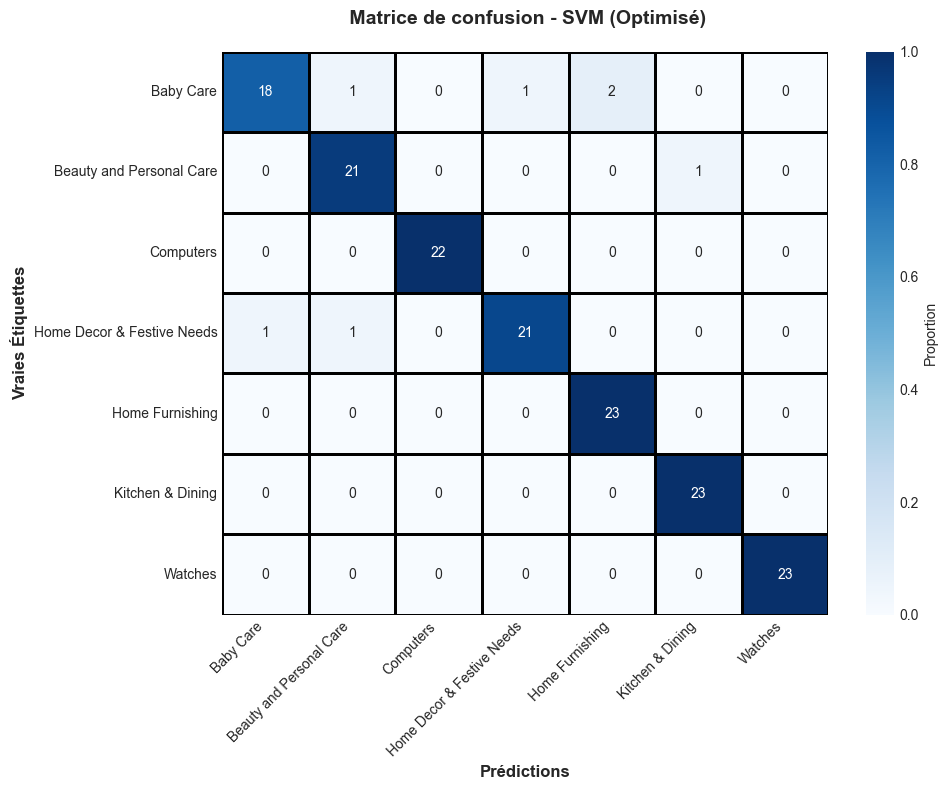

In [57]:
print("\n" + "="*80)
print(" ÉVALUATION DU MODÈLE OPTIMISÉ")
print("="*80 + "\n")

print(" Évaluation complète du modèle optimisé sur les 3 ensembles...\n")

# Évaluation complète
optimized_results = evaluate_model(
    optimized_model, X_train, X_val, X_test,
    y_train, y_val, y_test,
    f"{best_model_name} (Optimisé)",
    target_names
)
optimized_results['training_time'] = optimization_time
optimized_results['model'] = optimized_model

# Affichage des résultats
print_results(optimized_results, f"{best_model_name} (OPTIMISÉ)")

# Matrice de confusion du modèle optimisé
print("\n Matrice de confusion (Test Set) - Modèle Optimisé :\n")
plot_confusion_matrix(
    optimized_results['test']['confusion_matrix'],
    target_names,
    f"{best_model_name} (Optimisé)",
    save_path='../outputs/cm_optimized_model.png'
)

### COMPARAISON AVANT/APRÈS OPTIMISATION

In [58]:
print("\n" + "="*80)
print(" COMPARAISON AVANT/APRÈS OPTIMISATION")
print("="*80 + "\n")

# Métriques avant optimisation
before_opt = all_results[best_model_name]

# Tableau comparatif
comparison_opt = pd.DataFrame({
    'Version': ['Avant Optimisation', 'Après Optimisation', 'Différence Absolue'],
    'Train Acc (%)': [
        before_opt['train']['accuracy']*100,
        optimized_results['train']['accuracy']*100,
        (optimized_results['train']['accuracy'] - before_opt['train']['accuracy'])*100
    ],
    'Val Acc (%)': [
        before_opt['val']['accuracy']*100,
        optimized_results['val']['accuracy']*100,
        (optimized_results['val']['accuracy'] - before_opt['val']['accuracy'])*100
    ],
    'Test Acc (%)': [
        before_opt['test']['accuracy']*100,
        optimized_results['test']['accuracy']*100,
        (optimized_results['test']['accuracy'] - before_opt['test']['accuracy'])*100
    ],
    'Test F1': [
        before_opt['test']['f1_score'],
        optimized_results['test']['f1_score'],
        optimized_results['test']['f1_score'] - before_opt['test']['f1_score']
    ],
    'Test Precision': [
        before_opt['test']['precision'],
        optimized_results['test']['precision'],
        optimized_results['test']['precision'] - before_opt['test']['precision']
    ],
    'Test Recall': [
        before_opt['test']['recall'],
        optimized_results['test']['recall'],
        optimized_results['test']['recall'] - before_opt['test']['recall']
    ]
})

print("Tableau comparatif complet :")
print("="*80)
print(comparison_opt.to_string(index=False))

# Analyse détaillée
improvement_test_f1 = optimized_results['test']['f1_score'] - before_opt['test']['f1_score']
improvement_test_acc = (optimized_results['test']['accuracy'] - before_opt['test']['accuracy']) * 100


 COMPARAISON AVANT/APRÈS OPTIMISATION

Tableau comparatif complet :
           Version  Train Acc (%)  Val Acc (%)  Test Acc (%)  Test F1  Test Precision  Test Recall
Avant Optimisation      99.863574    96.202532      95.56962 0.954869        0.956236     0.955696
Après Optimisation      99.590723    96.202532      95.56962 0.954869        0.956236     0.955696
Différence Absolue      -0.272851     0.000000       0.00000 0.000000        0.000000     0.000000


### VISUALISATION COMPARATIVE AVANT/APRÈS


 VISUALISATION COMPARATIVE :



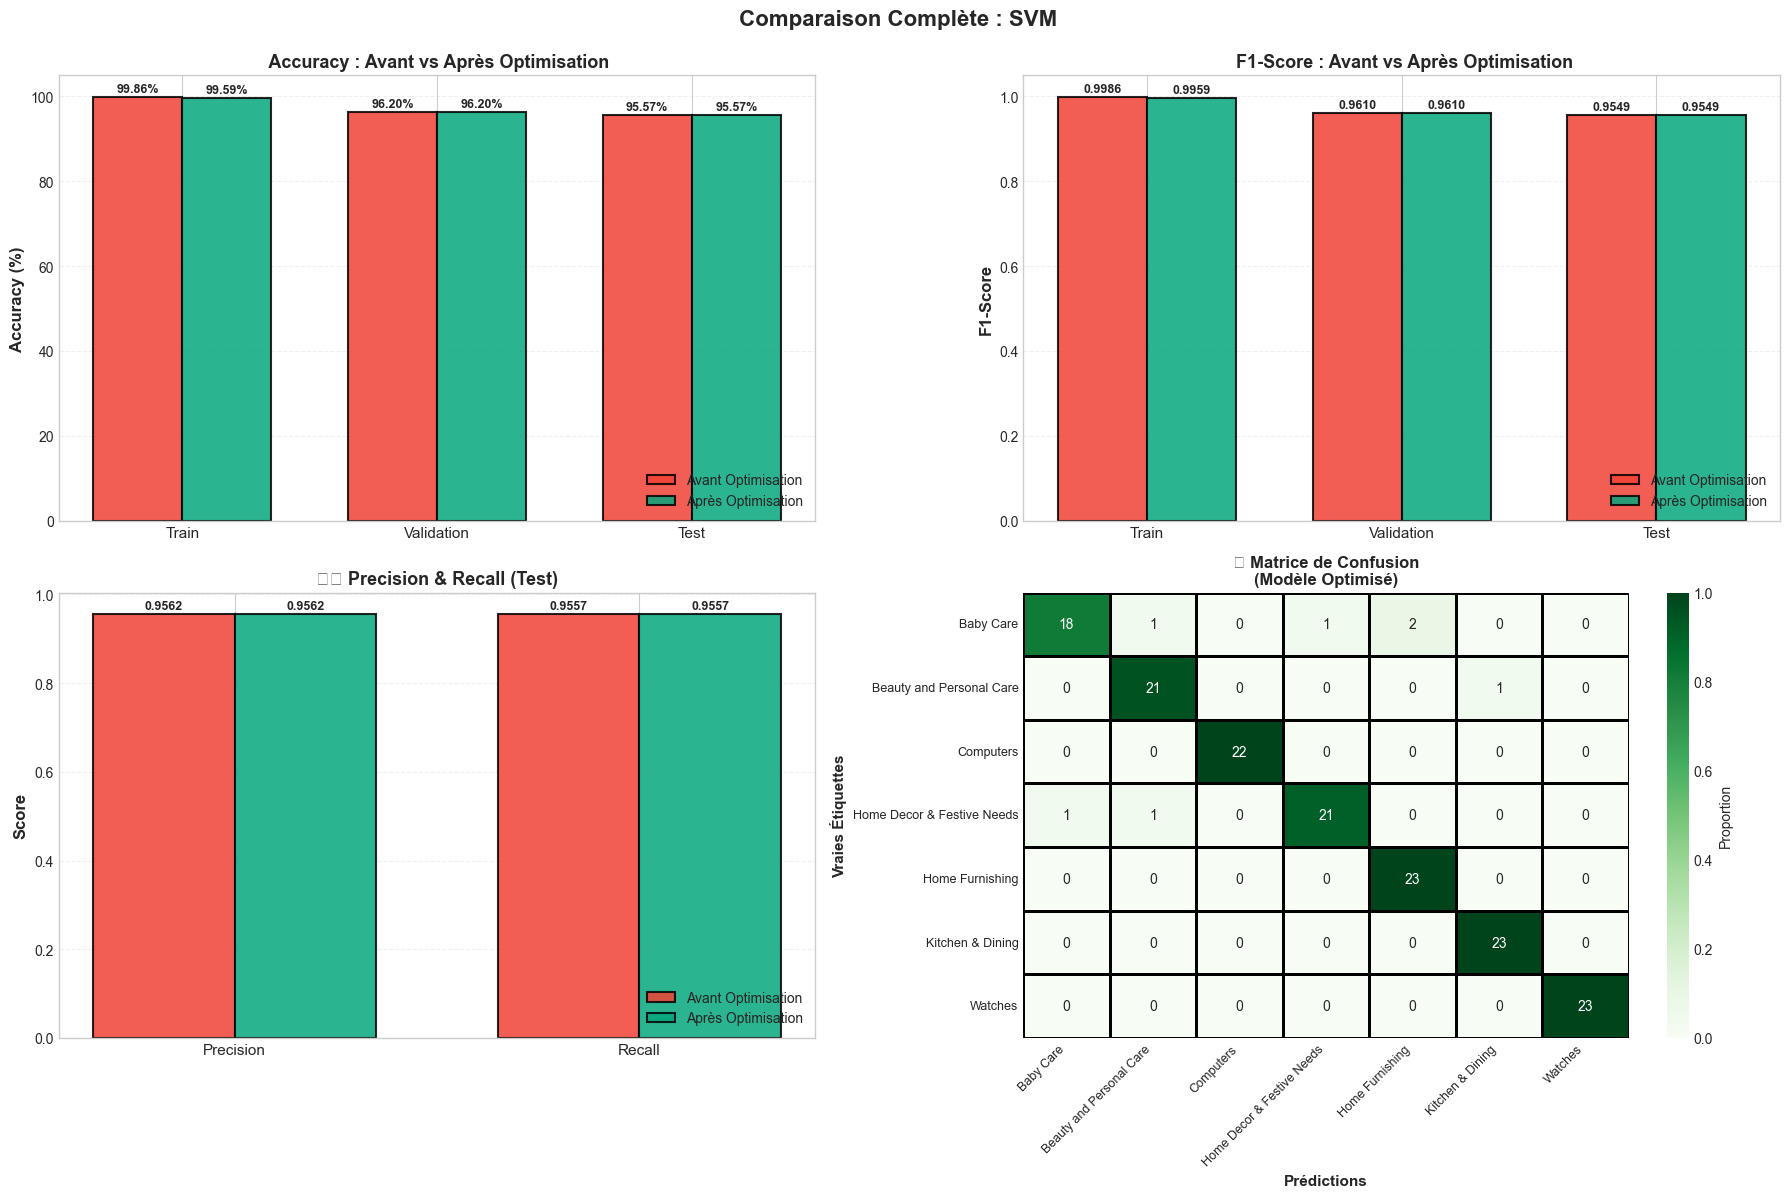

In [59]:
print("\n VISUALISATION COMPARATIVE :\n")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Comparaison Accuracy
ax = axes[0, 0]
metrics = ['Train', 'Validation', 'Test']
before_accs = [before_opt['train']['accuracy']*100,
               before_opt['val']['accuracy']*100,
               before_opt['test']['accuracy']*100]
after_accs = [optimized_results['train']['accuracy']*100,
              optimized_results['val']['accuracy']*100,
              optimized_results['test']['accuracy']*100]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, before_accs, width, label='Avant Optimisation',
               color=COLORS['warning'], edgecolor='black', linewidth=1.5, alpha=0.85)
bars2 = ax.bar(x + width/2, after_accs, width, label='Après Optimisation',
               color=COLORS['success'], edgecolor='black', linewidth=1.5, alpha=0.85)

ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title(' Accuracy : Avant vs Après Optimisation', 
            fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.2f}%', ha='center', va='bottom', 
                fontweight='bold', fontsize=9)

# 2. Comparaison F1-Score
ax = axes[0, 1]
before_f1s = [before_opt['train']['f1_score'],
              before_opt['val']['f1_score'],
              before_opt['test']['f1_score']]
after_f1s = [optimized_results['train']['f1_score'],
             optimized_results['val']['f1_score'],
             optimized_results['test']['f1_score']]

bars1 = ax.bar(x - width/2, before_f1s, width, label='Avant Optimisation',
               color=COLORS['warning'], edgecolor='black', linewidth=1.5, alpha=0.85)
bars2 = ax.bar(x + width/2, after_f1s, width, label='Après Optimisation',
               color=COLORS['success'], edgecolor='black', linewidth=1.5, alpha=0.85)

ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title(' F1-Score : Avant vs Après Optimisation', 
            fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.4f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=9)

# 3. Comparaison Precision & Recall
ax = axes[1, 0]
metrics_pr = ['Precision', 'Recall']
before_pr = [before_opt['test']['precision'], before_opt['test']['recall']]
after_pr = [optimized_results['test']['precision'], optimized_results['test']['recall']]

x_pr = np.arange(len(metrics_pr))

bars1 = ax.bar(x_pr - width/2, before_pr, width, label='Avant Optimisation',
               color=COLORS['warning'], edgecolor='black', linewidth=1.5, alpha=0.85)
bars2 = ax.bar(x_pr + width/2, after_pr, width, label='Après Optimisation',
               color=COLORS['success'], edgecolor='black', linewidth=1.5, alpha=0.85)

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('⚖️ Precision & Recall (Test)', fontsize=13, fontweight='bold')
ax.set_xticks(x_pr)
ax.set_xticklabels(metrics_pr, fontsize=11)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.4f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=9)

# 4. Matrice de confusion optimisée
ax = axes[1, 1]
cm_optimized = optimized_results['test']['confusion_matrix']
cm_normalized = cm_optimized.astype('float') / cm_optimized.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=cm_optimized, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names,
            linewidths=1, linecolor='black', cbar_kws={'label': 'Proportion'},
            ax=ax, vmin=0, vmax=1)

ax.set_xlabel('Prédictions', fontsize=11, fontweight='bold')
ax.set_ylabel('Vraies Étiquettes', fontsize=11, fontweight='bold')
ax.set_title(f'🔥 Matrice de Confusion\n(Modèle Optimisé)', 
            fontsize=12, fontweight='bold')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=9)

plt.suptitle(f' Comparaison Complète : {best_model_name}', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../outputs/optimization_comparison_detailed.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("="*80)

### SAUVEGARDE DU MODÈLE FINAL

In [62]:
print("\n" + "="*80)
print(" SAUVEGARDE DU MODÈLE FINAL")
print("="*80 + "\n")

# le meilleur modèle (avant ou après optimisation)
if improvement_test_f1 >= 0:
    final_model = optimized_model
    final_model_name = f"{best_model_name} (Optimisé)"
    final_f1 = optimized_results['test']['f1_score']
    final_acc = optimized_results['test']['accuracy']
    print(f"✅ Modèle final retenu : OPTIMISÉ (meilleur F1-Score)")
else:
    final_model = before_opt['model']
    final_model_name = best_model_name
    final_f1 = before_opt['test']['f1_score']
    final_acc = before_opt['test']['accuracy']
    print(f" Modèle final retenu : AVANT OPTIMISATION (meilleur F1-Score)")

# Sauvegarde
with open('../models/final_best_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print(f" Modèle sauvegardé : final_best_model.pkl")
print(f"   Nom      : {final_model_name}")
print(f"   Test F1  : {final_f1:.4f} ")
print(f"   Test Acc : {final_acc*100:.2f}%")

# Sauvegarde des resultats du modèle final
with open('../outputs/optimized_results.pkl', 'wb') as f:
    pickle.dump(optimized_results if improvement_test_f1 >=0 else before_opt, f)
# Sauvegarde aussi du modèle optimisé séparément
with open('../outputs/optimized_model.pkl', 'wb') as f:
    pickle.dump(optimized_model, f)

print(f" Modèle optimisé sauvegardé : optimized_model.pkl")

# Sauvegarde de tous les modèles
with open('../outputs/all_models.pkl', 'wb') as f:
    pickle.dump(all_results, f)

print(f" Tous les modèles sauvegardés : all_models.pkl ({len(all_results)} modèles)")

print("\n" + "="*80)


 SAUVEGARDE DU MODÈLE FINAL

✅ Modèle final retenu : OPTIMISÉ (meilleur F1-Score)
 Modèle sauvegardé : final_best_model.pkl
   Nom      : SVM (Optimisé)
   Test F1  : 0.9549 
   Test Acc : 95.57%
 Modèle optimisé sauvegardé : optimized_model.pkl
 Tous les modèles sauvegardés : all_models.pkl (5 modèles)



### SYNTHÈSE FINALE

In [61]:
print("\n" + "="*80)
print(" SYNTHÈSE FINALE DU NOTEBOOK 3")
print("="*80 + "\n")

print(" RÉCAPITULATIF COMPLET :\n")

summary = {
    "Dataset": "Flipkart (1050 produits)",
    "Classes": len(target_names),
    "Features": len(feature_names),
    "Split": "Train 70% / Val 15% / Test 15%",
    "Baseline": f"Logistic Regression ({baseline_test_acc*100:.2f}%)",
    "Modèles testés": len(all_results),
    "Critère de sélection": "F1-Score (weighted) 🎯",
    "Meilleur modèle (initial)": f"{best_model_name} (F1={best_f1:.4f})",
    "Optimisation": "GridSearchCV (3-fold CV, F1-Score)",
    "Modèle final": final_model_name,
    "Performance finale (F1)": f"{final_f1:.4f}",
    "Performance finale (Acc)": f"{final_acc*100:.2f}%",
    "Amélioration vs Baseline": f"{(final_acc - baseline_test_acc)*100:+.2f} points (Acc)"
}

for key, value in summary.items():
    print(f"{key:.<40} {value}")

print("\n" + "="*80)
print("📂 FICHIERS GÉNÉRÉS :")
print("="*80 + "\n")

files_generated = [
    "Modèles (.pkl):",
    "  • final_best_model.pkl - Modèle final retenu",
    "  • optimized_model.pkl - Modèle optimisé",
    "  • best_model_before_optimization.pkl - Avant optimisation",
    "  • all_models.pkl - Tous les modèles",
    "",
    "Résultats (.csv):",
    "  • models_comparison.csv - Tableau comparatif",
    "",
    "Visualisations (.png):",
    "  • cm_01_baseline_logistic_regression.png",
    "  • cm_02_random_forest.png",
    "  • cm_03_xgboost.png",
    "  • cm_04_svm_linear.png",
    "  • cm_05_gradient_boosting.png",
    "  • global_comparison_all_models.png",
    "  • optimization_comparison.png"
]

for file in files_generated:
    print(file)

print("\n" + "="*80)
print("✅ NOTEBOOK 3 TERMINÉ AVEC SUCCÈS ! 🎉")
print("="*80)
print(f"\n MODÈLE FINAL : {final_model_name}")
print(f"   Test F1-Score : {final_f1:.4f} 🎯")
print(f"   Test Accuracy : {final_acc*100:.2f}%")
print(f"   Amélioration vs Baseline : {(final_acc - baseline_test_acc)*100:+.2f} points")


 SYNTHÈSE FINALE DU NOTEBOOK 3

 RÉCAPITULATIF COMPLET :

Dataset................................. Flipkart (1050 produits)
Classes................................. 7
Features................................ 3200
Split................................... Train 70% / Val 15% / Test 15%
Baseline................................ Logistic Regression (94.94%)
Modèles testés.......................... 5
Critère de sélection.................... F1-Score (weighted) 🎯
Meilleur modèle (initial)............... SVM (F1=0.9549)
Optimisation............................ GridSearchCV (3-fold CV, F1-Score)
Modèle final............................ SVM (Optimisé)
Performance finale (F1)................. 0.9549
Performance finale (Acc)................ 95.57%
Amélioration vs Baseline................ +0.63 points (Acc)

📂 FICHIERS GÉNÉRÉS :

Modèles (.pkl):
  • final_best_model.pkl - Modèle final retenu
  • optimized_model.pkl - Modèle optimisé
  • best_model_before_optimization.pkl - Avant optimisation
  • a